# Notebook 03: Improved CNN Experiments

In this notebook we start from the baseline CNN developed in
`02_cnn_baseline.ipynb` and explore simple improvements to:

- reduce overfitting,
- improve validation and test accuracy,
- and understand how model capacity and regularization affect performance.

We keep the same data preprocessing and train/validation/test split so that
results are directly comparable to the baseline.



### 1. Setup and Configuration

In this section we:

- import the same libraries used in the baseline notebook,
- set global parameters (sample rate, Mel-spectrogram settings, etc.),
- and fix random seeds for reproducibility.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split

# Make sure we see same results each run
np.random.seed(42)
tf.random.set_seed(42)

# Data directory (resolve turns it to absolute path)
DATA_DIR = Path("../data").resolve()

# Audio/mel-spectrogram parameters
SAMPLE_RATE = 16000
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128

# Train/val/test split ratios
TEST_SIZE = 0.2 # 20% of the data for testing
VAL_SIZE = 0.2  # 20% of the remaining training pool (after removing test set) going to validation set

# Class labels
CLASS_NAMES = ["dog", "cat", "bird"]
label_to_index = {label: idx for idx, label in enumerate(CLASS_NAMES)}


### 2. Data Loading and Preprocessing

We reuse the same preprocessing pipeline as in the baseline notebook:

1. Load the raw audio file with `librosa.load` at 16 kHz.
2. Convert to a Mel-spectrogram with `librosa.feature.melspectrogram`.
3. Convert to log scale (`librosa.power_to_db`) and normalize.
4. Pad or crop each spectrogram to a fixed 128×128 window.
5. Stack them into arrays `X` (inputs) and `y` (one-hot labels).

For clarity, we keep the helper functions here in this notebook. Later, they
could be moved into a shared `src/` module.



In [10]:
def load_mel_spectrogram(path, sample_rate=SAMPLE_RATE, n_fft=N_FFT,
                         hop_length=HOP_LENGTH, n_mels=N_MELS):
    y, sr = librosa.load(path, sr=sample_rate)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    # Normalize roughly to [0, 1]
    S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-8)
    return S_norm

def pad_or_crop_spectrogram(S, target_time_bins=128):
    n_mels, n_frames = S.shape

    if n_mels != N_MELS:
        raise ValueError(f"Expected {N_MELS} Mel bands, got {n_mels}")

    if n_frames == target_time_bins:
        return S

    if n_frames < target_time_bins:
        # Pad with zeros along time axis
        pad_width = target_time_bins - n_frames
        S_padded = np.pad(S, ((0, 0), (0, pad_width)), mode="constant")
        return S_padded

    # If too long, centrally crop
    start = (n_frames - target_time_bins) // 2
    end = start + target_time_bins
    return S[:, start:end]

def load_example_for_model(audio_path: Path, label: str) -> tuple[np.ndarray, np.ndarray]:
    """Load one audio file and return (X, y) ready for model."""
    S_norm = load_mel_spectrogram(audio_path)
    S_fixed = pad_or_crop_spectrogram(S_norm, target_time_bins=128)
    
    # Add channel dimension → (128, 128, 1)
    X = S_fixed.astype("float32")[..., np.newaxis]
    
    # One-hot label
    num_classes = len(CLASS_NAMES)
    y = np.zeros(num_classes, dtype="float32")
    y[label_to_index[label]] = 1.0
    
    return X, y

def load_dataset(max_files_per_class: int = 20):
    """Load dataset with same structure as baseline."""
    X_list = []
    y_list = []
    
    for label in CLASS_NAMES:
        class_dir = DATA_DIR / label
        wav_files = sorted(class_dir.glob("*.wav"))
        
        for audio_path in wav_files[:max_files_per_class]:
            X, y = load_example_for_model(audio_path, label)
            X_list.append(X)
            y_list.append(y)
    
    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    return X, y


### 2.1 Load dataset into `X` and `y`

Next we apply these helper functions to the dataset directory and build:

- `X`: array of shape `(num_examples, 128, 128, 1)`
- `y`: one-hot labels of shape `(num_examples, 3)`



In [11]:
X, y = load_dataset(max_files_per_class=20)
print(f"Dataset shape: X={X.shape}, y={y.shape}")


Dataset shape: X=(60, 128, 128, 1), y=(60, 3)


### 3. Train / Validation / Test Split

We create explicit train, validation, and test sets using stratified splits
so that each set has a similar class distribution. This mirrors the split
used in the baseline notebook to keep results comparable.



In [12]:
# Assume X, y are already built
y_indices = np.argmax(y, axis=1)

X_train_full, X_test, y_train_full, y_test, y_train_full_idx, y_test_idx = train_test_split(
    X,
    y,
    y_indices,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=VAL_SIZE,
    random_state=42,
    stratify=y_train_full_idx,
)

X_train.shape, X_val.shape, X_test.shape


((38, 128, 128, 1), (10, 128, 128, 1), (12, 128, 128, 1))

We now have:

- `X_train`: training inputs
- `X_val`: validation inputs (used during training to monitor generalization)
- `X_test`: held-out test inputs (used only at the end for final evaluation)

All splits are stratified, so each class appears in similar proportions.



### 4. Experiment 1 – Smaller Dense Layer

In the baseline model, the Dense(64) layer after Flatten accounts for the
majority of parameters (~4.2M) and likely contributes to overfitting.

In this experiment we:

- Keep the convolution + pooling part the same as the baseline.
- Replace `Dense(64, relu)` with `Dense(32, relu)` (fewer parameters).
- Train the model with the same settings as the baseline.
- Compare validation and test accuracy to see if a smaller dense layer
  improves generalization.


In [13]:
def build_cnn_small_dense(input_shape=(128, 128, 1), num_classes=3):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(32, activation="relu"),  # smaller dense layer
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

small_dense_model = build_cnn_small_dense()
small_dense_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     2,097,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,099 (8.07 MB)

 Trainable params: 2,116,099 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

### 4.1 Training the small-dense model

We now train the model on the same train/validation split and reuse the
`plot_training_curves` function from the baseline notebook to visualize
loss and accuracy.


In [15]:
EPOCHS = 10
BATCH_SIZE = 8

small_dense_model = build_cnn_small_dense()

history_small_dense = small_dense_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.2632 - loss: 1.3165 - val_accuracy: 0.3000 - val_loss: 1.1193
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5526 - loss: 1.0845 - val_accuracy: 0.3000 - val_loss: 1.1040
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4474 - loss: 1.0850 - val_accuracy: 0.4000 - val_loss: 1.1057
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4211 - loss: 1.0693 - val_accuracy: 0.4000 - val_loss: 1.1178
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3684 - loss: 1.0411 - val_accuracy: 0.4000 - val_loss: 1.1328
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4474 - loss: 0.9990 - val_accuracy: 0.4000 - val_loss: 1.1343
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5263 - loss: 0.9472 - val_accuracy: 0.4000 - val_loss: 1.1211
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6053 - loss: 0.8783 - val_accuracy: 0.3000 - val_loss: 1.0961



What’s happening:

small_dense_model = build_cnn_small_dense()
→ Creates a fresh model with:

The architecture we defined (Conv/Pool/Conv/Pool/Flatten/Dense(32)/Dense(3)),

Initial random weights (but deterministic because of the seed).

model.fit(...):

Uses the optimizer (adam), loss (categorical_crossentropy), and metrics (accuracy) set in compile.

For each epoch:

Goes through X_train, y_train in batches of size 8.

Updates weights based on gradients.

Evaluates on (X_val, y_val) at the end of the epoch.

Returns a History object with training stats.


Plot the curves

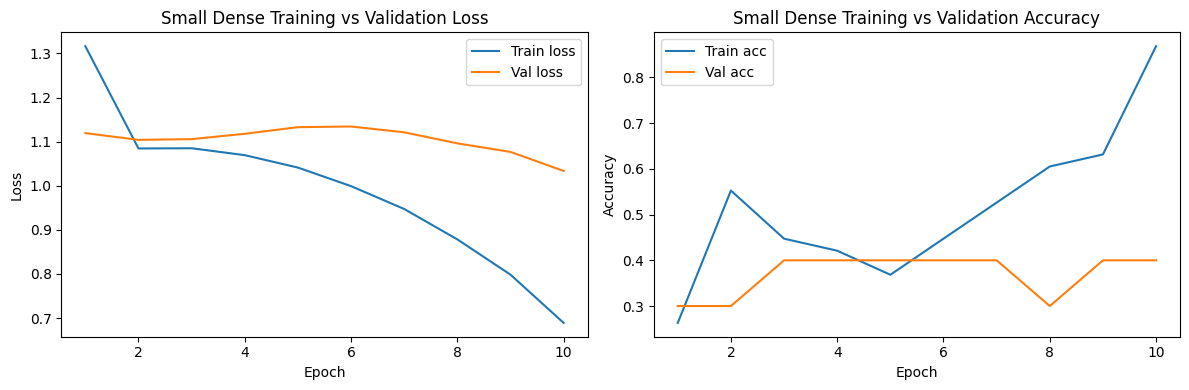

In [16]:
plot_training_curves(history_small_dense, title_prefix="Small Dense")


Evaluate on the test set


In [17]:
test_loss_small, test_acc_small = small_dense_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Small-dense test loss:", test_loss_small)
print("Small-dense test accuracy:", test_acc_small)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4167 - loss: 0.9805
Small-dense test loss: 0.9804858565330505
Small-dense test accuracy: 0.4166666567325592


This does:

Runs the trained small-dense model on the held-out test set.

Computes loss and accuracy on that set.

test_acc_small is the number you’ll compare to your baseline test accuracy (~0.4167).

You’ll then be able to say:

Baseline:

Val acc ≈ 0.60

Test acc ≈ 0.42

Params ≈ 4.21M

Small dense:

Val acc = ?

Test acc = ?

Params ≈ 2.12M

If small-dense gets similar or better val/test accuracy with fewer parameters, that’s a nice win and a good point to discuss in your report.